<a href="https://colab.research.google.com/github/JMCRMatheusCastro/c-digo-em-MEF-para-barras/blob/main/Dime_Flexo_Comp_Norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2024-11-26 13:13:21.419 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 13:13:21.508 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-11-26 13:13:21.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 13:13:21.515 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 13:13:21.517 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 13:13:21.520 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 13:13:21.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 13:13:21.524 Thread 'MainThread': mi

DeltaGenerator()

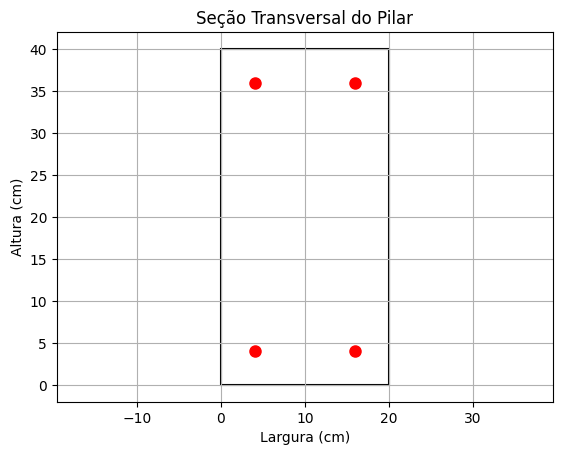

In [6]:
# Universidade Federal de Pernambuco (UFPE)
# José Matheus de Castro Rodrigues
# Data: 29/11/2024

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import streamlit as st

# Função para plotar a seção transversal
def plotarSecao(b, h, dLinha, nLinha, n, Beta):
    fig, ax = plt.subplots()
    ax.add_patch(plt.Rectangle((0, 0), b, h, edgecolor='k', linewidth=1.5, fill=False))
    ax.set_title("Seção Transversal do Pilar")
    ax.set_xlabel("Largura (cm)")
    ax.set_ylabel("Altura (cm)")
    for i in range(nLinha):
        y_pos = Beta[i] * h
        x_pos = np.linspace(dLinha, b - dLinha, n[i])
        ax.plot(x_pos, [y_pos] * len(x_pos), 'ro', markersize=8)
    ax.axis('equal')
    ax.grid(True)
    return fig

# Função para calcular tensões no aço
def calcularTensaoAco(epsilon_s, Es, fyd):
    epsilon_yd = fyd / Es
    sigma_sd = np.where(np.abs(epsilon_s) <= epsilon_yd, Es * epsilon_s, np.sign(epsilon_s) * fyd)
    return sigma_sd

# Função para calcular Fxi
def calcularFxi(x, h, epsilon_0, k, Beta, n, Es, fyd, b, Sigmacd, Nd, Md):
    xi = x / h
    epsilon_s = epsilon_0 * ((xi - Beta) / (xi - k))
    sigma_sd = calcularTensaoAco(epsilon_s, Es, fyd)
    rc = min(0.8 * xi, 1)
    Betac = min(0.5 * 0.8 * xi, 0.5)
    nu = Nd / (b * h * Sigmacd)
    mi = Md / (b * h**2 * Sigmacd)
    SOM1 = np.sum(n * sigma_sd)
    SOM2 = np.sum(n * Beta * sigma_sd)
    return (mi - (0.5 * nu) + rc * Betac) * SOM1 + (nu - rc) * SOM2

# Restrição não-linear
def restricaoNaoLinear(x, h, epsilon_0, k, Beta, n, Es, fyd, b, Sigmacd, Nd, Md):
    return calcularFxi(x, h, epsilon_0, k, Beta, n, Es, fyd, b, Sigmacd, Nd, Md)

# Configuração do Streamlit
st.title("Dimensionamento da Área de Aço - Flexo-Compressão")
st.sidebar.header("Parâmetros de Entrada")

# Entrada de parâmetros
b = st.sidebar.number_input("Base da seção (cm)", value=20.0)
h = st.sidebar.number_input("Altura da seção (cm)", value=40.0)
dLinha = st.sidebar.number_input("Distância até bordas (cm)", value=4.0)
nLinha = st.sidebar.slider("Número de camadas", 1, 5, value=2)
n = np.array([st.sidebar.number_input(f"Nº barras camada {i+1}", min_value=1, value=2) for i in range(nLinha)])
fck = st.sidebar.number_input("Fck do concreto (kN/cm²)", value=2.0)
fyk = st.sidebar.number_input("Fyk do aço (kN/cm²)", value=50.0)
Nk = st.sidebar.number_input("Esforço normal de serviço (kN)", value=410.0)
distMomento = st.sidebar.number_input("Distância para momento fletor (cm)", value=25.0)

# Propriedades calculadas
Es = 21000  # Módulo de elasticidade do aço
fcd = fck / 1.4
Sigmacd = 0.85 * fcd
fyd = fyk / 1.15
Mk = Nk * distMomento
Nd = 1.4 * Nk
Md = 1.4 * Mk

# Parâmetros geométricos
delta = dLinha / h
Beta = delta + ((nLinha - np.arange(1, nLinha + 1)) * (1 - 2 * delta)) / (nLinha - 1)
epsilon_0 = 0.002
epsilon_u = 0.0035
k = 1 - (epsilon_0 / epsilon_u)

# Resolver o problema de otimização
x0 = h / 2
bounds = [(0, None)]
resultado = minimize(lambda x: calcularFxi(x, h, epsilon_0, k, Beta, n, Es, fyd, b, Sigmacd, Nd, Md),
                     x0, bounds=bounds, constraints={'type': 'eq', 'fun': lambda x: restricaoNaoLinear(x, h, epsilon_0, k, Beta, n, Es, fyd, b, Sigmacd, Nd, Md)})

# Resultados
x_opt = resultado.x[0]
xi_opt = x_opt / h
epsilon_s_opt = epsilon_0 * ((xi_opt - Beta) / (xi_opt - k))
sigma_sd_opt = calcularTensaoAco(epsilon_s_opt, Es, fyd)
rc = min(0.8 * xi_opt, 1)
Betac = min(0.5 * 0.8 * xi_opt, 0.5)
nu = Nd / (b * h * Sigmacd)
mi = Md / (b * h**2 * Sigmacd)
SOM1 = np.sum(n * sigma_sd_opt)
SOM2 = np.sum(n * Beta * sigma_sd_opt)
omega = np.sum(n) * fyd * (0.5 * nu - mi - rc * Betac) / SOM2
Ast = abs(omega * b * h * Sigmacd / fyd)

# Exibir resultados
st.subheader("Resultados")
st.write(f"Profundidade da linha neutra (cm): {x_opt:.2f}")
st.write(f"Valor da função objetivo: {resultado.fun:.4f}")
st.write(f"Área de aço total (Ast) requerida (cm²): {Ast:.4f}")

# Exibir gráfico
st.subheader("Seção Transversal")
fig = plotarSecao(b, h, dLinha, nLinha, n, Beta)
st.pyplot(fig)
